In [52]:
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
from numba import jit

In [53]:
data_A = np.loadtxt('../data/TSPA.csv', delimiter=';').astype(np.int64)
data_B = np.loadtxt('../data/TSPB.csv', delimiter=';').astype(np.int64)
data_C = np.loadtxt('../data/TSPC.csv', delimiter=';').astype(np.int64)
data_D = np.loadtxt('../data/TSPD.csv', delimiter=';').astype(np.int64)

In [54]:
def create_cost_matrix(data):
    x = data[:, :1]
    y = data[:, 1:2]
    cost = data[:, 2:3]
    return (((x - x.reshape(1, -1))**2 + (y - y.reshape(1, -1))**2) ** (1/2) + cost.reshape(1, -1)).round().astype(np.int64)

In [55]:
cost_matrix_A = create_cost_matrix(data_A)

In [56]:
cost_matrix_A

array([[  84, 2032, 2098, ..., 4159, 3783, 1514],
       [1633,  483, 2398, ..., 3349, 2266,  817],
       [ 720, 1419, 1462, ..., 3640, 3149,  964],
       ...,
       [2782, 2371, 3641, ..., 1461, 2908, 2554],
       [2558, 1440, 3302, ..., 3060, 1309, 1773],
       [1234,  936, 2062, ..., 3651, 2718,  364]], dtype=int64)

In [57]:
cost_matrix_B = create_cost_matrix(data_B)

In [58]:
cost_matrix_B

array([[ 928, 2934, 1498, ..., 1282, 1015, 2598],
       [1998, 1864, 1461, ..., 1008, 1949, 3567],
       [2166, 3065,  260, ..., 1582, 1685, 3135],
       ...,
       [1613, 2275, 1245, ...,  597, 1538, 3156],
       [1373, 3243, 1375, ..., 1565,  570, 2189],
       [1750, 3655, 1619, ..., 1977,  983, 1776]], dtype=int64)

In [59]:
cost_matrix_C = create_cost_matrix(data_C)

In [60]:
cost_matrix_D = create_cost_matrix(data_D)

## TSP with regret

Pseudocode:
1) Create a greedy cycle for the initial node using NN heuristic
2) While cycle length is less than floor(all nodes / 2) do:<br>
    
    2.1) calculate change in distance that would occur when inserting a new node into the cycle<br>

    2.2) calculate k-regret for each possible new node<br>
    
    2.3) determine which node to add (one with the greatest regret) and in what place (best possible place for this node to be added i.e. smallest cost)<br>
    
    2.4) add the new node into the cycle 

In [61]:
## Simple cycle greed
def calculate_k_regret_test(mat, bool_mask, k, solution, weighted=False):
    anti_solution = sorted(list(set(range(200)) - set(solution)))
    
    new_mat = (mat[solution][:, anti_solution].T
    + np.c_[mat[anti_solution][:, solution][:, 1:], mat[anti_solution][:, solution][:, :1]]
    - np.append(np.diagonal(mat[solution][:, solution], 1), mat[solution][:, solution][-1:, :1]).reshape(1, -1))

    biggest_regret = 0 # what's yours? 
    id_biggest = None
    
    sorted_mat = np.min(new_mat, axis=1).reshape(-1, 1)
    
    regrets = sorted_mat[:, :1]
    
    biggest_regret = regrets.min()
    
    id_biggest = np.where(regrets == biggest_regret)[0][0]
    
    new_node_id = bool_mask.index[anti_solution][id_biggest]
    node_to_append = bool_mask.index[solution][np.where(new_mat[id_biggest] == new_mat[id_biggest].min())[0]][0]
    
    
    return new_node_id, node_to_append, biggest_regret

In [62]:
@jit()
def calculate_k_regret_newest(mat, bool_mask, k, solution, weighted=False):
    total = np.array(sorted(list(set(range(200)))), dtype=np.int64)
    anti_solution = np.array(sorted(list(set(range(200)) - set(solution))))
    
    new_mat = (mat[solution][:, anti_solution].T
    + np.c_[mat[anti_solution][:, solution][:, 1:], mat[anti_solution][:, solution][:, :1]]
    - np.append(np.diagonal(mat[solution][:, solution], 1), mat[solution][:, solution][-1:, :1]).reshape(1, -1))

    biggest_regret = 0 # what's yours? 
    id_biggest = None
    
    sorted_mat = np.sort(new_mat, axis=1)

    if weighted:
        regrets = (sorted_mat[:, 1:k] - sorted_mat[:, :1]).sum(axis=1) * (1 / sorted_mat[:, :1])
    else:
        regrets = (sorted_mat[:, 1:k] - sorted_mat[:, :1]).sum(axis=1)
    
    # print(regrets.shape, sorted_mat.shape)

    biggest_regret = regrets.max()
    
    id_biggest = np.where(regrets == biggest_regret)[0][0]
    
    new_node_id = total[anti_solution][id_biggest]
    node_to_append = total[solution][np.where(new_mat[id_biggest] == new_mat[id_biggest].min())[0]][0]
    
    
    return new_node_id, node_to_append, biggest_regret

In [63]:
@jit()
def tsp_regret(cost_matrix=np.array([[1], [1]]), starting_node=0, max_nodes=100, k=2, weighted=False):
    solution_set = set([starting_node])
    solution = list([starting_node])

    ## regular greedy
    total = np.array(sorted(list(set(range(200)))), dtype=np.int64)
    for i in range(k-1):
        previous_node = solution[-1]
        # bool_mask = pd.Series(range(len(cost_matrix))).isin(solution_set)
        
        bool_mask = np.array(sorted(list(set(range(200)) - set(solution))))
        matrix_id = np.where(cost_matrix[previous_node][bool_mask] == cost_matrix[previous_node][bool_mask].min())[0][0]
        new_node = total[bool_mask][matrix_id]
        solution_set.add(new_node)
        solution.append(new_node)
    
    ## tsp with regret
    while len(solution_set) < max_nodes:
        # bool_mask_solution_nodes = pd.Series(range(len(cost_matrix))).isin(solution_set)
        new_node_id, node_to_append, regret_value = calculate_k_regret_newest(cost_matrix, k, k, np.array(solution), weighted)
        solution.insert(solution.index(node_to_append)+1, new_node_id)
        solution_set.add(new_node_id)
        
    solution.append(solution[0])

    return solution

In [64]:
def plot(data, solution):
    data_ordered = np.array([data[i] for i in solution])
    all_data = np.array([data[i] for i in range(200)])

    plt.figure(figsize=(10, 10), dpi=80)

    plt.scatter(data_ordered[:,0], data_ordered[:,1], s=data_ordered[:,2]/data_ordered[:,2].max()*200, c='b')
    plt.scatter(all_data[:,0], all_data[:,1], s=all_data[:,2]/all_data[:,2].max()*200, c='b')
    plt.plot(data_ordered[:,0], data_ordered[:,1], 'y-')
    plt.plot([data_ordered[0,0], data_ordered[-1,0]], [data_ordered[0,1], data_ordered[-1,1]], 'y-')
    plt.show()

In [65]:
def calculate_performance(cycle, cost_matrix):
    total_sum = 0
    for i in range(len(cycle)-1):
        total_sum += cost_matrix[cycle[i], cycle[i+1]] 
    return total_sum

In [66]:
def test_solution(algorithm, cost_matrix, k, weighted=False):
    costs = []
    for i in range(len(cost_matrix)):
        cycle = algorithm(cost_matrix, i, 100, k, weighted)
        total_cost = calculate_performance(cycle, cost_matrix)
        costs.append(total_cost)
    costs = np.array(costs)
    return costs.min(), costs.max(), costs.mean()

In [67]:
def present_results(min, max, average):
    print('MINIMUM:', min)
    print('MAXIMUM:', max)
    print('AVERAGE:', average)

## Dataset A

In [68]:
cycle = tsp_regret(cost_matrix_A, 0, 100, k=2)

C:\Users\hubra\AppData\Local\Temp\ipykernel_3440\3657907819.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "tsp_regret" failed type inference due to: Invalid use of type(CPUDispatcher(<function calculate_k_regret_newest at 0x000001F8145A3640>)) with parameters (array(int64, 2d, C), int64, int64, array(int64, 1d, C), Literal[bool](False))

During: resolving callee type: type(CPUDispatcher(<function calculate_k_regret_newest at 0x000001F8145A3640>))
During: typing of call at C:\Users\hubra\AppData\Local\Temp\ipykernel_3440\3657907819.py (21)


File "..\..\..\AppData\Local\Temp\ipykernel_3440\3657907819.py", line 21:
<source missing, REPL/exec in use?>

  @jit()
C:\Users\hubra\AppData\Local\Temp\ipykernel_3440\3657907819.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "tsp_regret" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.

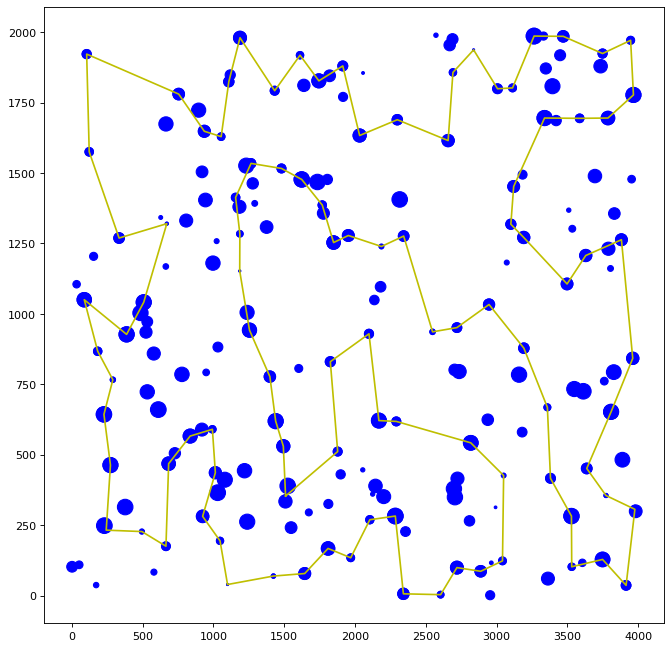

In [69]:
plot(data_A, cycle)

In [70]:
cycle = tsp_regret(cost_matrix_A, 0, 100, k=2, weighted=True)

C:\Users\hubra\AppData\Local\Temp\ipykernel_3440\3657907819.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "tsp_regret" failed type inference due to: Invalid use of type(CPUDispatcher(<function calculate_k_regret_newest at 0x000001F8145A3640>)) with parameters (array(int64, 2d, C), int64, int64, array(int64, 1d, C), bool)

During: resolving callee type: type(CPUDispatcher(<function calculate_k_regret_newest at 0x000001F8145A3640>))
During: typing of call at C:\Users\hubra\AppData\Local\Temp\ipykernel_3440\3657907819.py (21)


File "..\..\..\AppData\Local\Temp\ipykernel_3440\3657907819.py", line 21:
<source missing, REPL/exec in use?>

  @jit()
C:\Users\hubra\AppData\Local\Temp\ipykernel_3440\3657907819.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "tsp_regret" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

Fi

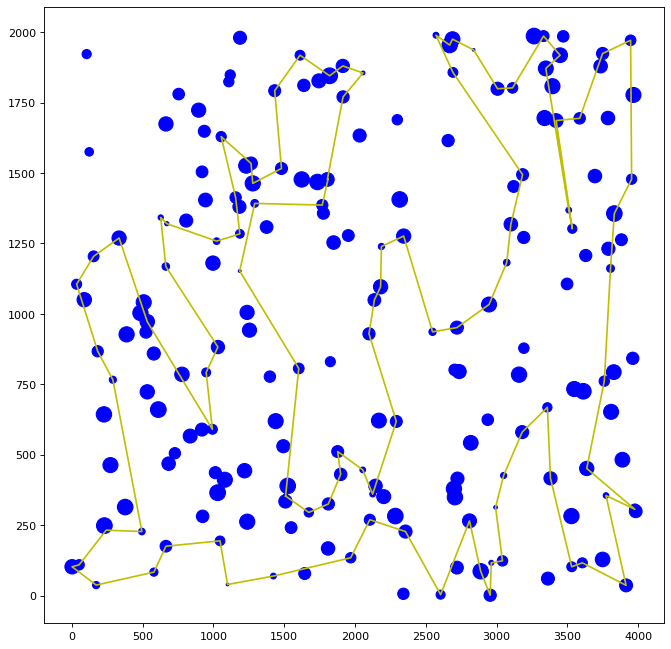

In [71]:
plot(data_A, cycle)

In [72]:
%%timeit
test_solution(tsp_regret, cost_matrix_A, k=2)

6.64 s ± 600 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [73]:
present_results(*test_solution(tsp_regret, cost_matrix_A, k=3))

MINIMUM: 107721
MAXIMUM: 121568
AVERAGE: 115005.76


In [74]:
present_results(*test_solution(tsp_regret, cost_matrix_A, k=4))

MINIMUM: 106090
MAXIMUM: 123272
AVERAGE: 114436.815


In [75]:
present_results(*test_solution(tsp_regret, cost_matrix_A, k=2, weighted=True))

MINIMUM: 75052
MAXIMUM: 78929
AVERAGE: 76698.215


In [76]:
present_results(*test_solution(tsp_regret, cost_matrix_A, k=3, weighted=True))

MINIMUM: 75611
MAXIMUM: 80321
AVERAGE: 77066.72


In [77]:
present_results(*test_solution(tsp_regret, cost_matrix_A, k=4, weighted=True))

MINIMUM: 75796
MAXIMUM: 79738
AVERAGE: 77071.97


## Dataset B

In [78]:
cycle = tsp_regret(cost_matrix_B, 0, 100, k=2)

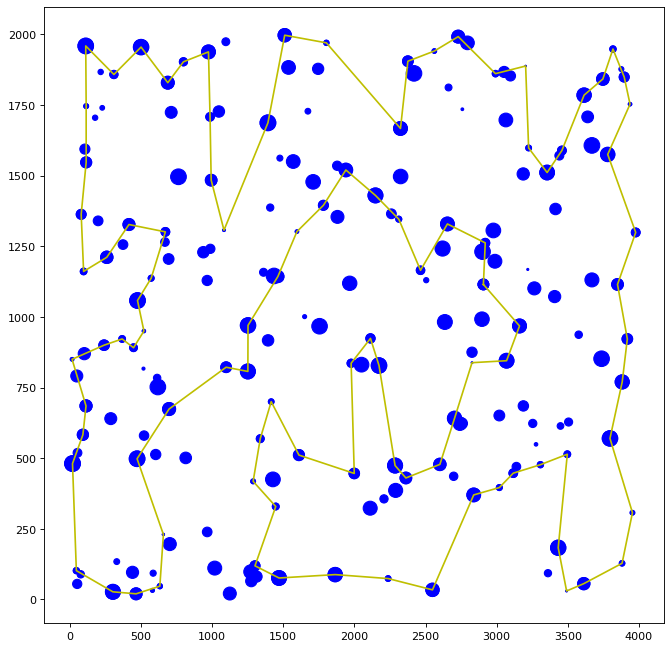

In [79]:
plot(data_B, cycle)

In [80]:
cycle = tsp_regret(cost_matrix_B, 0, 100, k=2, weighted=True)

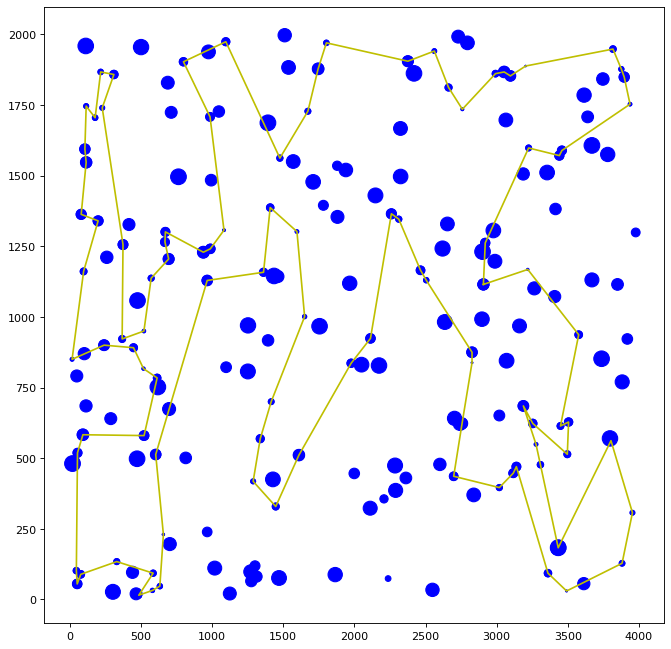

In [81]:
plot(data_B, cycle)

In [82]:
present_results(*test_solution(tsp_regret, cost_matrix_B, k=2))

MINIMUM: 109774
MAXIMUM: 128550
AVERAGE: 118806.91


In [83]:
present_results(*test_solution(tsp_regret, cost_matrix_B, k=2, weighted=True))

MINIMUM: 68743
MAXIMUM: 76640
AVERAGE: 70150.105


In [84]:
test_solution(tsp_regret, cost_matrix_B, k=3)

(108842, 123740, 116158.555)

In [85]:
test_solution(tsp_regret, cost_matrix_B, k=4)

(103762, 124621, 114999.72)

In [86]:
results_a = dict()

In [87]:
results_a['greedy_nn'] = [84840, 95932, 87741.23]
results_a['greedy_cycle'] = [74573, 79158, 76387.4]
results_a['greedy_cycle_regret_unweighted'] = [104829, 124764, 116240.25]
results_a['greedy_cycle_regret_weighted'] = [75052, 78929, 76698.215]

<AxesSubplot: >

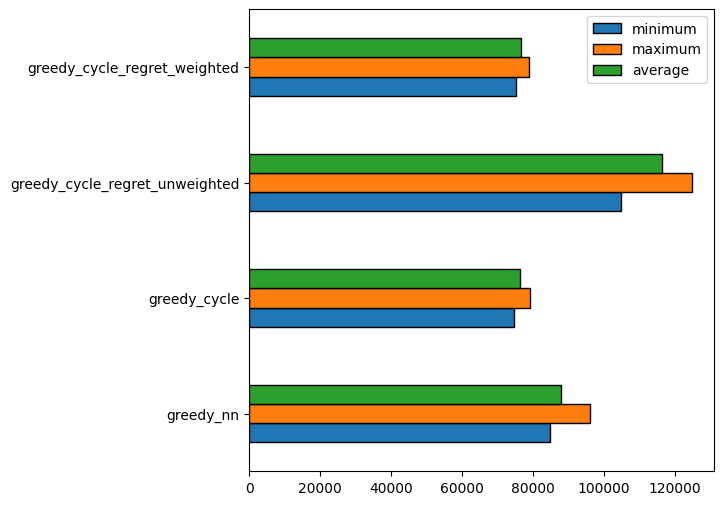

In [88]:
pd.DataFrame(results_a, index=['minimum', 'maximum', 'average']).T.plot(kind='barh', edgecolor='k', figsize=(6, 6))

In [89]:
results_b = dict()

In [90]:
results_b['greedy_nn'] = [77417, 81600, 79096]
results_b['greedy_cycle'] = [67684, 75068, 69961]
results_b['greedy_cycle_regret_unweighted'] = [109774, 128550, 118806.91]
results_b['greedy_cycle_regret_weighted'] = [68743, 76640, 70150.105]

<AxesSubplot: >

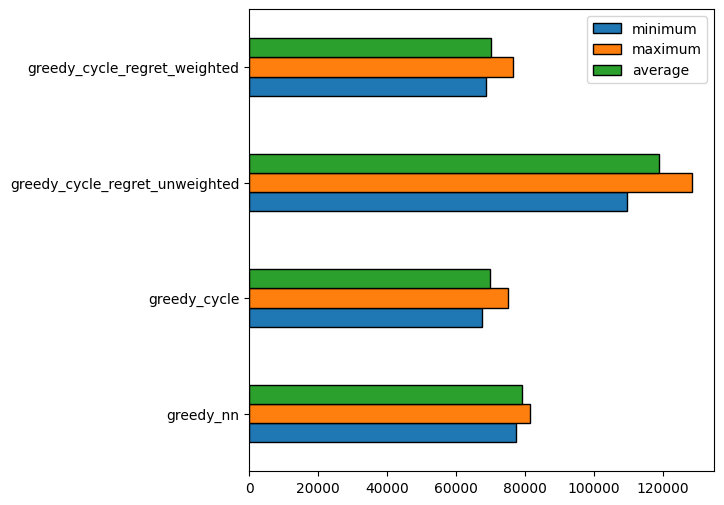

In [91]:
pd.DataFrame(results_b, index=['minimum', 'maximum', 'average']).T.plot(kind='barh', edgecolor='k', figsize=(6, 6))

In [92]:
%%timeit
test_solution(tsp_regret, cost_matrix_A, k=2, weighted=True)

8.4 s ± 397 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Dataset C

In [93]:
present_results(*test_solution(tsp_regret, cost_matrix_C, k=2))

MINIMUM: 65095
MAXIMUM: 73090
AVERAGE: 69013.725


In [94]:
present_results(*test_solution(tsp_regret, cost_matrix_C, k=2, weighted=True))

MINIMUM: 51279
MAXIMUM: 57710
AVERAGE: 54713.55


In [95]:
test_solution(tsp_regret, cost_matrix_C, k=3)

(63937, 71900, 67965.77)

In [96]:
test_solution(tsp_regret, cost_matrix_C, k=4)

(62844, 72053, 67465.845)

## Dataset D

In [97]:
present_results(*test_solution(tsp_regret, cost_matrix_D, k=2))

MINIMUM: 64682
MAXIMUM: 74903
AVERAGE: 70442.125


In [98]:
present_results(*test_solution(tsp_regret, cost_matrix_D, k=2, weighted=True))

MINIMUM: 47293
MAXIMUM: 60077
AVERAGE: 52938.82


In [99]:
test_solution(tsp_regret, cost_matrix_D, k=3)

(64439, 72288, 68531.165)

In [100]:
test_solution(tsp_regret, cost_matrix_D, k=4)

(63648, 73551, 67684.065)